# Data analysis of NeoMesh, LTE-M and Thread

In this document I will perform some data analysis on the above mentioned technologies.


## Imports and utilities

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.signal import find_peaks
from utils import *

## Identifying the beacon and shed TX events

To identify these we use the single sample that I got of the single node with no neighbours
with IO markers. Since we know that the CTS signal is sent during a TX sched event we can just identify
events where this line is set to see which event is which. And with no neighbour there will be no other
activity on the mesh module, except the occational full becon scan.

### Finding periodical events

To find periodical events in our signal we apply the autocorrelation to it. This will give us the lag where similar signals overlap when doing the autocorrelation. This means that we can use this to actually find the best candidates
for similar events.

In [3]:
df = import_ppk("ppk_measurements/single_idle_with_cts_pin.csv")

df["Current(uA)"] = df["Current(uA)"] / 1000
df["CTS"] = df["CTS"] / 1000

/home/oskar/.venvp3/jupyter/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
tx_schd = (118.74299999999494, 121.22899999999936)
beacon = (730.0599999999977, 735.3099999999977)


fig, (ax1, ax2) = plt.subplots(2,1, sharey=True)
fig.dpi=150

df.plot(ax=ax1, y="Current(uA)", xlim=beacon, title="Single NeoMesh beacon event", ylabel="$mA$", xlabel="Time [ms]")
ax1.grid(alpha=0.6)

ax1.legend(["Current"])
mean_curr = df["Current(uA)"][beacon[0]:beacon[1]].mean()
event_duration_s = (beacon[1] - beacon[0]) / 1000.0
print(f"Mean current during beacon event: {mean_curr / 1000.0} mA")
print(f"Mean charge use of event: {mean_curr * event_duration_s} uC")

df.plot(ax=ax2, xlim=tx_schd, title="Single NeoMesh scheduled tx event", ylabel="$mA$", xlabel="Time [ms]")
ax2.grid(alpha=0.6)
ax2.legend(["Current", "CTS signal"])

mean_curr = df["Current(uA)"][tx_schd[0]:tx_schd[1]].mean()
event_duration_s = (tx_schd[1] - tx_schd[0]) / 1000.0
print(f"Mean current during TX sched event: {mean_curr / 1000.0} mA")
print(f"Mean charge use of event: {mean_curr * event_duration_s} uC")
plt.tight_layout()
save_plot("beacon_and_tx_events.png")

<IPython.core.display.Javascript object>

Mean current during beacon event: 0.020722453939163502 mA
Mean charge use of event: 0.10879288318060838 uC
Mean current during TX sched event: 0.009494193072580644 mA
Mean charge use of event: 0.023602563978477483 uC


## Trying to identify some RX sched events.

In [5]:
df = import_ppk("ppk_measurements/nm_idle_1s_1s_1_neighbour.csv")
reasonable_cutout = df[12731.1:13016]

/home/oskar/.venvp3/jupyter/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


After locating a nice cutout we just manually identify some of the events in there.

In [6]:
schd_tx = (12867.11, 12869.52)
schd_rx = (13004.009, 13006.617)
beacon = (12740.66, 12745.97)
reasonable_cutout.plot(y=0)
plt.grid(alpha=0.6)
plt.tight_layout()
plt.legend(["Current"])
plt.show()

schd_tx_current = reasonable_cutout["Current(uA)"][schd_tx[0]:schd_tx[1]].mean()
schd_rx_current = reasonable_cutout["Current(uA)"][schd_rx[0]:schd_rx[1]].mean()
beacon_current = reasonable_cutout["Current(uA)"][beacon[0]:beacon[1]].mean()

print(f"schd_tx = {schd_tx_current / 1000} mA, {schd_tx_current * (schd_tx[1] - schd_tx[0])/1000} uC")
print(f"schd_rx = {schd_rx_current / 1000} mA, {schd_rx_current * (schd_rx[1] - schd_rx[0])/1000} uC")
print(f"beacon = {beacon_current / 1000} mA, {beacon_current * (beacon[1] - beacon[0])/1000} uC")

<IPython.core.display.Javascript object>

schd_tx = 12.75985987966805 mA, 30.751262309998143 uC
schd_rx = 15.70700188888889 mA, 40.96386092622497 uC
beacon = 21.8537964613936 mA, 116.04365920998887 uC


# Identifying beacons, TX and RX events

In this data set we have a node that is in the middle of two other nodes.
All the nodes are idle so no other events than the beacons and scheduled RX and TX events are present in the dataset.


In [7]:
data_set = "ppk_measurements/beacon_tx_rx_rx.csv"
df = import_ppk(data_set)
df["Current(uA)"] = df["Current(uA)"] / 1000
df = df.rename(columns={"Current(uA)": "Current"})
data_set = "ppk_measurements/single_full_beakon_scan.csv"
full_beacon = import_ppk(data_set)
full_beacon["Current(uA)"] = full_beacon["Current(uA)"] / 1000
full_beacon.rename(columns={"Current(uA)":"Current"}, inplace=True)

In [8]:
beacon = df[3.7:9.06]
rx1 = df[116.781:119.387]
tx = df[276.843:279.297]
rx2 = df[384.124:386.819]

data = [
    (beacon, "Beacon event"),
    (tx, "Scheduled transmit"),
    (rx1, "Scheduled receive"),
    (full_beacon, "Full beacon scan"),
]


fig, axis = plt.subplots(2,2, sharey=True)
fig.dpi = 150
for i, d in enumerate(data):
    x = int(i/2)
    y = i % 2
    ax = axis[x,y]
    frame = d[0]
    title = d[1]
    mean_current = frame["Current"].mean()
    duration = (frame.index[-1] - frame.index[0])
    charge_spent = duration * mean_current
    print(f"{title}\nDuration: {duration}\nMean current {mean_current:.4} mA\nCharge spent {charge_spent:.4} uC\n")
    
    frame.plot(
        ax=ax,
        y="Current",
        title=title,
        xlabel="Time [ms]",
        ylabel="$mA$"
    )
    ax.grid(alpha=0.6)

plt.tight_layout()
plt.show()
save_plot("nm_event_overview.png")

<IPython.core.display.Javascript object>

Beacon event
Duration: 5.350000000000364
Mean current 21.7 mA
Charge spent 116.1 uC

Scheduled transmit
Duration: 2.4399999999986903
Mean current 12.72 mA
Charge spent 31.04 uC

Scheduled receive
Duration: 2.5900000000001455
Mean current 15.71 mA
Charge spent 40.7 uC

Full beacon scan
Duration: 1014.6800000000003
Mean current 24.27 mA
Charge spent 2.463e+04 uC



## Finding the mean sleep current

In [44]:
data_set = "ppk_measurements/120s_idle.csv"
df = import_ppk(data_set)
df = df.rename(columns={"Current(uA)": "Current"})

/home/oskar/.venvp3/jupyter/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [45]:
df.Current.mean()

178.44810572985278

In [10]:
sleep = df[df["Current"] < 800]

print(f"Percentage of time spent in sleep: {100*sleep.size / df.size} %")
mean_sleep_current = sleep["Current"].mean()
print(f"Mean sleep current of NeoMesh is {mean_sleep_current} uA")
fig, ax = plt.subplots()
fig.dpi=150
sleep.plot(ax=ax, title="Signal, with radio events filtered out", xlabel="Time [ms]", ylabel="$\mu{}A$")
plt.grid(alpha=0.6)
plt.tight_layout()
save_plot("sleep_current.png")
plt.show()

Percentage of time spent in sleep: 99.0115820927559 %
Mean sleep current of NeoMesh is 0.8955930792621853 uA


<IPython.core.display.Javascript object>

# Identify transmisisons with payloads

In [11]:
data_set = "ppk_measurements/single_21_payload_transmit.csv"
df = import_ppk(data_set).rename(columns={"Current(uA)": "Current"})
df.Current = df.Current / 1000
df.CTS = df.CTS/1000

In [12]:
fig, ax = plt.subplots()
fig.dpi=150
df.plot(ax=ax, title="Single 21 byte transmit", ylabel="mA", xlabel="Time [ms]")
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()
save_plot("singe_21_byte_tx.png")

mean_current = df.Current.mean()
duration = df.index[-1] - df.index[0]
energy_spent = mean_current * duration

print(f"Mean current: {mean_curr} mA")
print(f"Event duration: {duration} ms")
print(f"Event energy cost: {energy_spent} uC")

<IPython.core.display.Javascript object>

Mean current: 9.494193072580645 mA
Event duration: 4.5899999999965075 ms
Event energy cost: 79.81169066093926 uC


In [28]:
beacon = np.array([
    (21.74,5.080,110.45),
    (21.77,5.057,110.08),
    (21.82,5.060,110.40),
    (21.94,5.214,114.37),
    (21.71,5.069,110.07),
    (21.93,5.097,111.78),
    (22.02,5.058,111.40),
    (22.20,5.239,116.30),
    (22.03,5.052,111.29),
    (22.01,5.052,111.19),
    (22.15,5.198,115.17),
    (21.28,5.172,110.07),
    (21.69,5.090,110.41),
    (21.54,5.120,110.28),
    (21.36,5.138,109.76),
    (21.70,5.261,114.20),
    (21.43,5.119,109.70),
    (21.46,5.106,109.61),
    (21.32,5.100,108.76),
    (21.69,5.271,114.33),
    (20.93,5.207,108.99),
    (21.38,5.119,109.46),
    (21.62,5.302,114.62),
    (20.02,5.683,113.80),
    (21.53,5.123,110.30),
    (21.92,5.243,114.97),
])

tx = np.array([
    (13.23,2.426,32.11),
    (13.17,2.399,31.60),
    (13.15,2.382,31.32),
    (13.00,2.421,31.49),
    (13.10,2.371,31.06),
    (13.05,2.370,30.95),
    (13.02,2.371,30.87),
    (13.09,2.380,31.17),
    (13.11,2.393,31.38),
    (13.19,2.417,31.89),
    (13.22,2.373,31.36),
    (12.79,2.457,31.43),
    (12.56,2.413,30.30),
    (12.41,2.445,30.35),
    (12.82,2.349,30.12),
    (13.73,1.902,26.11),
    (12.21,2.497,30.50),
    (12.39,2.430,30.12),
    (12.36,2.473,30.56),
    (12.39,2.430,30.12),
    (12.86,2.428,31.22),
    (12.43,2.448,30.44),
    (12.57,2.421,30.44),
    (12.88,2.432,31.33),
    (12.23,2.443,29.87),
    
])

tx_30dbm = np.array([
    (10.32,2.461),
    (10.42,2.448),
    (10.33,2.451),
    (9.86,2.452),
    (10.54,2.415),
    (10.33,2.446),
    (10.24,2.454),
    (10.27,2.449),
    (10.17,2.465),
    (10.22,2.478),
])

beacon_30dbm = np.array([
    (21.88,5.079),
    (21.71,5.131),
    (21.63,5.131),
])

rx = np.array([
    (15.97,2.578,41.19),
    (16.49,2.605,42.95),
    (16.16,2.613,42.23),
    (16.18,2.520,40.80),
    (16.35,2.537,42.07),
    (16.16,2.512,40.61),
    (15.79,2.559,40.43),
    (16.17,2.547,41.18),
    (15.73,2.490,39.18),
    (16.48,2.605,42.94),
    (15.90,2.531,40.25),
    (15.83,2.556,40.46),
    (14.21,3.081,43.78),
    (16.05,2.526,40.55),
    (16.91,2.625,44.40),
    (15.81,2.551,40.33),
    (15.96,2.561,40.88),
    (15.90,2.619,41.66),
    (15.94,2.551,40.68),
    (15.88,2.529,40.17),
    (15.83,2.553,40.42),
    (15.81,2.551,40.34),
    (16.26,2.572,41.82),
    (15.92,2.632,41.89),
    (15.16,2.632,39.90),
])

full_beacon = np.array([
    (24.52,1.005,24.66e3),
    (24.50,1.005,24.64e3),
    (24.51,1.005,24.65e3),
    (24.53,1.005,24.68e3),
    (24.53,1.005,24.67e3),
    (24.50,1.005,24.64e3),
    (24.56,1.005,24.71e3),
])

tx_21b = np.array([
    (17.72,4.563),
    (17.55,4.707),
    (17.72,4.637),
    (17.25,4.169),
    (17.61,4.556),
    (17.28,4.666),
    (17.65,4.657),
    (17.76,4.585),
    (17.64,4.675),
    (17.72,4.556)
])

def print_data(name, data):
    print(f"{name}:", "N:", len(data))
    means = np.mean(data, axis=(0))
    var = np.var(data, axis=(0))
    print(f"mean current {means[0]} mA ({var[0]})")
    print(f"duration: {means[1]} ms ({var[1]})")
    if len(var) == 3 and len(means) == 3:
        print(f"energy: {means[2]} uC ({var[2]})")
    print()

print_data("Beacons",beacon)
print_data("TX", tx)
print_data("RX", rx)
print_data("Full beacons", full_beacon)
print_data("30dBm TX", tx_30dbm)
print_data("30dBm Beacons", beacon_30dbm)
print_data("Transmit 21 bytes", tx_21b)


Beacons: N: 26
mean current 21.622692307692304 mA (0.1896196745562131)
duration: 5.162692307692306 ms (0.016426597633136097)
energy: 111.60615384615383 uC (4.89960828402367)

TX: N: 25
mean current 12.8384 mA (0.14538943999999995)
duration: 2.39484 ms (0.011352534400000001)
energy: 30.724400000000006 uC (1.2396566399999995)

RX: N: 25
mean current 15.953999999999999 mA (0.2301759999999999)
duration: 2.58544 ms (0.011737286399999996)
energy: 41.2444 uC (1.5244086399999994)

Full beacons: N: 7
mean current 24.521428571428572 mA (0.00038367346938774163)
duration: 1.005 ms (0.0)
energy: 24664.285714285714 uC (538.7755102040817)

30dBm TX: N: 10
mean current 10.27 mA (0.028659999999999998)
duration: 2.4519 ms (0.00023609000000000016)

30dBm Beacons: N: 3
mean current 21.74 mA (0.01086666666666663)
duration: 5.113666666666667 ms (0.0006008888888889001)

Transmit 21 bytes: N: 10
mean current 17.59 mA (0.029939999999999873)
duration: 4.5771 ms (0.021203090000000025)



Predicted mean current: 225.75704869550532 uA 234.7972586955053
Predicted mean current(-30dBM): 219.60614163950527 uA 228.64635163950527
Predicted mean mean current while transmitting: 275.5185807168052 uA 284.5625338395053
Predicition complete model: 234.7972586955053 uA
Predicted mean current for config 1: 234.7972586955053 uA
Predicted mean current for config 2: 24.91538077928599 uA
Predicted mean current for config 3: 20.394380779285992 uA
Predicted mean current for config 4: 17.419599425135303 uA
Predicted mean current for config 5: 12.898599425135302 uA
Predicted mean current for config 6: 228.64635163950527 uA
Predicted mean current for config 7: 12.693569189935301 uA
Predicted mean current for config 8: 31.772288321135303 uA


<IPython.core.display.Javascript object>


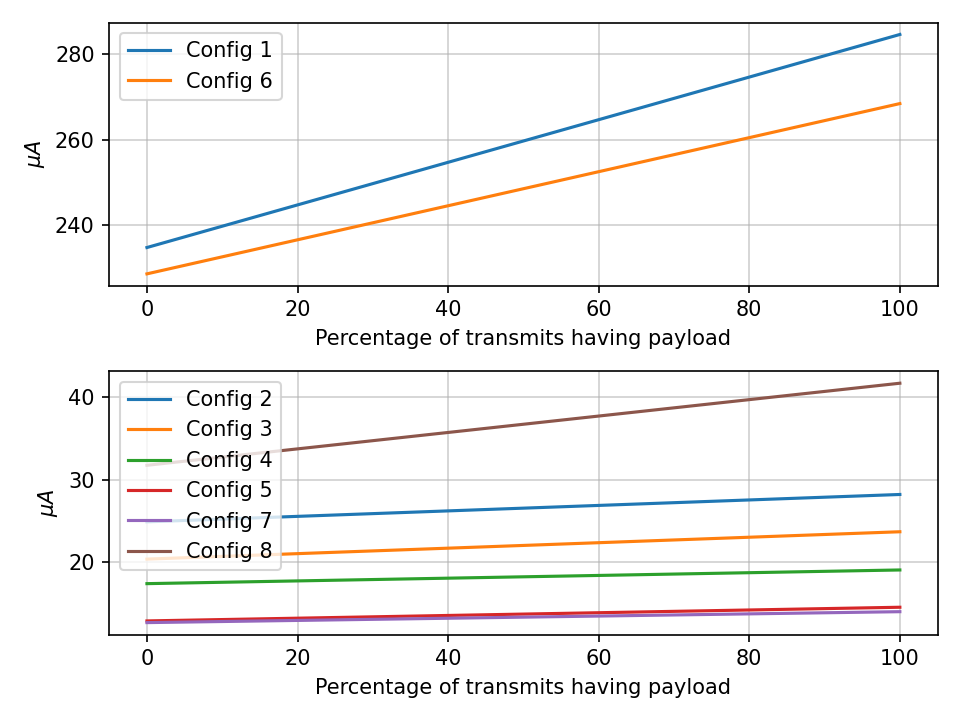

35.7535103326553


In [9]:
def neomesh_mean_current(T_tx, T_beacon, N_full_beacon, neighbours, attenuated=False, transmit_percentage=0.0):
    assert(0.0 <= transmit_percentage <= 1.0)
    beacon_mean_current = 21.622692307692304e-3
    tx_mean_current = 12.8384e-3 if not attenuated else 10.27e-3
    rx_mean_current = 15.953999999999999e-3
    tx_payload_mean_current = 17.59e-3 if not attenuated else 17.58e-3 * (10.27 / 12.8384)
    full_beacon_mean_current = 4.521e-3
    sleep_mean_current = 0.895e-6

    T_full_beacon = T_beacon * N_full_beacon

    beacon_percentage = 5.162692307692306e-3 / T_beacon
    tx_percentage = 2.39484e-3 / T_tx
    rx_percentage = 2 * 2.58544e-3 / T_tx
    tx_payload_percentage = 4.5771e-3 / T_tx
    full_beacon_percentage = T_beacon / T_full_beacon

    sleep_percentage = 1 - (beacon_percentage + tx_percentage + rx_percentage - full_beacon_percentage)
    mean_current = 0
    mean_current += sleep_percentage_complete * sleep_mean_current
    mean_current += beacon_percentage * beacon_mean_current
    mean_current += (1- transmit_percentage) * tx_percentage * tx_mean_current
    mean_current += transmit_percentage * tx_payload_percentage * tx_payload_mean_current
    mean_current += rx_percentage * rx_mean_current
    mean_current += full_beacon_percentage * full_beacon_mean_current
    return mean_current

beacon_mean_current = 21.622692307692304e-3
tx_mean_current = 12.8384e-3
rx_mean_current = 15.953999999999999e-3
tx_payload_mean_current = 17.59e-3
full_beacon_mean_current = 4.521e-3

tx_attentuated_mean_current = 10.27e-3


sleep_mean_current = 0.895e-6

total_time = 360

T_beacon = 1
T_tx = 1
N_full_beacon = 500
T_full_beacon = T_beacon * N_full_beacon

beacon_percentage = 5.162692307692306e-3 / T_beacon
tx_percentage = 2.39484e-3 / T_tx
rx_percentage = 2 * 2.58544e-3 / T_tx
tx_payload_percentage = 4.5771e-3 / T_tx
full_beacon_percentage = T_beacon / T_full_beacon

sleep_percentage = 1 - (beacon_percentage + tx_percentage + rx_percentage)
sleep_percentage_complete = sleep_percentage - full_beacon_percentage
tx_sleep_percentage = 1 - (beacon_percentage + tx_payload_percentage + rx_percentage + full_beacon_percentage)

total_mean_current = sleep_percentage * sleep_mean_current + beacon_percentage * beacon_mean_current + tx_percentage * tx_mean_current + rx_percentage * rx_mean_current
total_attenuated_mean_current = sleep_percentage * sleep_mean_current + beacon_percentage * beacon_mean_current + tx_percentage * tx_attentuated_mean_current + rx_percentage * rx_mean_current
total_transmit_mean_current = tx_sleep_percentage * sleep_mean_current + beacon_percentage * beacon_mean_current + tx_payload_percentage * tx_payload_mean_current + rx_percentage * rx_mean_current
total_complete_current = sleep_percentage_complete * sleep_mean_current + beacon_percentage * beacon_mean_current + tx_percentage * tx_mean_current + rx_percentage * rx_mean_current + full_beacon_percentage * full_beacon_mean_current
print(f"Predicted mean current: {total_mean_current * 1000*1000} uA {neomesh_mean_current(1, 1, 500, 2)*1000*1000}")
print(f"Predicted mean current(-30dBM): {total_attenuated_mean_current * 1000 * 1000} uA {neomesh_mean_current(1, 1, 500, 2, attenuated=True) * 1000 * 1000}")
print(f"Predicted mean mean current while transmitting: {total_transmit_mean_current * 1000 * 1000} uA {neomesh_mean_current(1, 1, 500, 2, transmit_percentage=1.0) * 1000*1000}")
print(f"Predicition complete model: {total_complete_current * 1000 * 1000} uA")

configs = [
    (1, 1, 500, False),
    (15, 15, 500, False),
    (15, 15, 1000, False),
    (30, 30, 500, False),
    (30, 30, 1000, False),
    (1, 1, 500, True),
    (30, 30, 1000, True),
    (5, 30, 1000, False),
]
data = {}
for n, config in enumerate(configs):
    print(f"Predicted mean current for config {n + 1}: {neomesh_mean_current(config[0], config[1], config[2], 2, attenuated=config[3], transmit_percentage=0.0)*1000*1000} uA")
    data[f"Config {n+1}"] = [neomesh_mean_current(config[0], config[1], config[2], 2, attenuated=config[3], transmit_percentage=i/100.0)*1000**2 for i in range(101)]

df = pd.DataFrame(data)

fig, ax = plt.subplots(2,1)
fig.dpi = 150
df.plot(ax=ax[0], y=["Config 1", "Config 6"], xlabel="Percentage of transmits having payload", ylabel="$\mu{}A$")
df.plot(ax=ax[1], y=[f"Config {n}" for n in [2, 3, 4, 5, 7, 8]], xlabel="Percentage of transmits having payload", ylabel="$\mu{}A$")
for a in ax:
    a.grid(alpha=.6)
plt.tight_layout()
plt.show()
save_plot("config_performance_overview.png")
conf7 = configs[7]
print(neomesh_mean_current(conf7[0],conf7[1], conf7[2], 2, transmit_percentage=0.4) * 1000 * 1000)

In [69]:
df = import_dlog("nm_idle_1.csv")
df.Curr = df.Curr * 1000

<IPython.core.display.Javascript object>


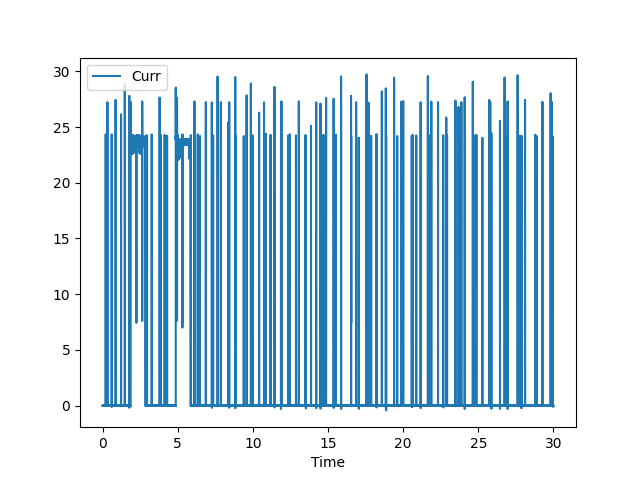

0.19614075082762872

In [70]:

df.plot(y="Curr")

df.Curr[6.24:].mean()